In [1]:
# @title Step 1: Install Requirements (Run this once)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, avg, current_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType
import time
import random
import json
import shutil

# Clean up any old data from previous runs to prevent errors
if os.path.exists("iot_data"):
    shutil.rmtree("iot_data")
os.makedirs("iot_data")

print("✅ Setup Complete. Ready to start!")

✅ Setup Complete. Ready to start!


In [4]:
# @title Step 2: Start Generating IoT Data
import time
import random
import json
import os

# Define the folder where our data will act as a "stream"
output_folder = "iot_data"

# Make sure the folder exists (just in case)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print(f"📡 Simulating IoT Sensors... Data is being written to '/content/{output_folder}/'")
print("⚠️ Let this run for 30-60 seconds, then press the STOP button to finish data generation.\n")

try:
    # We will loop 100 times to generate data (unless you stop it earlier)
    for i in range(1, 101):

        # We will create a list to hold the readings for this second
        current_batch_data = []

        # We simulate 3 different sensors sending data at the same time
        for device_id in ["Sensor_A", "Sensor_B", "Sensor_C"]:

            # Create a dictionary representing one sensor reading
            reading = {
                "device_id": device_id,
                # Random temperature between 20.0 and 35.0 degrees
                "temperature": round(random.uniform(20.0, 35.0), 2),
                # Random humidity between 30.0% and 60.0%
                "humidity": round(random.uniform(30.0, 60.0), 2),
                # The current time (timestamp) of the reading
                "timestamp": time.time()
            }
            # Add this reading to our batch list
            current_batch_data.append(reading)

        # Define the file name for this batch (e.g., reading_1.json, reading_2.json)
        file_path = f"{output_folder}/reading_{i}.json"

        # Open the file and write the data into it
        with open(file_path, 'w') as f:
            for entry in current_batch_data:
                # Convert the python dictionary to a JSON string and write it
                f.write(json.dumps(entry) + "\n")

        # Print a message so we know it's working
        print(f"📄 Batch {i} sent: Data written to {file_path}")

        # Wait for 3 seconds before generating the next batch (simulating real-time delay)
        time.sleep(3)

except KeyboardInterrupt:
    # This handles the user pressing the Stop button gracefully
    print("\n🛑 Data generation stopped by user.")

📡 Simulating IoT Sensors... Data is being written to '/content/iot_data/'
⚠️ Let this run for 30-60 seconds, then press the STOP button to finish data generation.

📄 Batch 1 sent: Data written to iot_data/reading_1.json
📄 Batch 2 sent: Data written to iot_data/reading_2.json
📄 Batch 3 sent: Data written to iot_data/reading_3.json
📄 Batch 4 sent: Data written to iot_data/reading_4.json
📄 Batch 5 sent: Data written to iot_data/reading_5.json
📄 Batch 6 sent: Data written to iot_data/reading_6.json
📄 Batch 7 sent: Data written to iot_data/reading_7.json
📄 Batch 8 sent: Data written to iot_data/reading_8.json
📄 Batch 9 sent: Data written to iot_data/reading_9.json
📄 Batch 10 sent: Data written to iot_data/reading_10.json
📄 Batch 11 sent: Data written to iot_data/reading_11.json
📄 Batch 12 sent: Data written to iot_data/reading_12.json
📄 Batch 13 sent: Data written to iot_data/reading_13.json
📄 Batch 14 sent: Data written to iot_data/reading_14.json
📄 Batch 15 sent: Data written to iot_data/

In [7]:
# @title Step 3 (Final Fix): Debug & Run Analytics
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import time

# --- DEBUG CHECK ---
# Check if the data actually exists
data_path = "/content/iot_data"
if not os.path.exists(data_path) or len(os.listdir(data_path)) == 0:
    print("❌ ERROR: No data files found!")
    print("👉 ACTION: Please go back and run 'Step 2' again to generate data.")
else:
    file_count = len(os.listdir(data_path))
    print(f"✅ FOUND DATA: {file_count} files are ready to process.")

    # --- START SPARK ---
    spark = SparkSession.builder \
        .appName("IoT_Project") \
        .master("local[*]") \
        .getOrCreate()

    # Define Schema
    schema = StructType([
        StructField("device_id", StringType(), True),
        StructField("temperature", DoubleType(), True),
        StructField("humidity", DoubleType(), True),
        StructField("timestamp", DoubleType(), True)
    ])

    # Read Stream (Using Full Path & maxFilesPerTrigger to force updates)
    input_df = spark.readStream \
        .schema(schema) \
        .option("maxFilesPerTrigger", 10) \
        .json(data_path)

    # Calculate Stats
    stats_df = input_df.groupBy("device_id").agg(
        avg("temperature").alias("avg_temp"),
        avg("humidity").alias("avg_humidity")
    )

    # Output to Memory
    print("🚀 Starting Stream... Watch the tables below!")
    query = stats_df.writeStream \
        .outputMode("complete") \
        .format("memory") \
        .queryName("sensor_stats") \
        .start()

    # Show Dashboard 10 times
    try:
        for i in range(10):
            # Wait a moment for Spark to process the first batch
            time.sleep(3)
            print(f"\n--- 📊 Live IoT Dashboard (Update {i+1}/10) ---")
            spark.sql("SELECT device_id, round(avg_temp, 2) as Temp_C, round(avg_humidity, 2) as Humidity FROM sensor_stats ORDER BY device_id").show()

    except KeyboardInterrupt:
        print("Stopped streaming.")

    query.stop()

✅ FOUND DATA: 100 files are ready to process.
🚀 Starting Stream... Watch the tables below!

--- 📊 Live IoT Dashboard (Update 1/10) ---
+---------+------+--------+
|device_id|Temp_C|Humidity|
+---------+------+--------+
+---------+------+--------+


--- 📊 Live IoT Dashboard (Update 2/10) ---
+---------+------+--------+
|device_id|Temp_C|Humidity|
+---------+------+--------+
+---------+------+--------+


--- 📊 Live IoT Dashboard (Update 3/10) ---
+---------+------+--------+
|device_id|Temp_C|Humidity|
+---------+------+--------+
+---------+------+--------+


--- 📊 Live IoT Dashboard (Update 4/10) ---
+---------+------+--------+
|device_id|Temp_C|Humidity|
+---------+------+--------+
| Sensor_A| 27.17|   40.66|
| Sensor_B| 27.75|    42.4|
| Sensor_C| 27.31|   41.49|
+---------+------+--------+


--- 📊 Live IoT Dashboard (Update 5/10) ---
+---------+------+--------+
|device_id|Temp_C|Humidity|
+---------+------+--------+
| Sensor_A| 28.37|   42.82|
| Sensor_B| 28.25|   45.43|
| Sensor_C| 2

In [8]:
# @title Step 4: Storage Layer (Save to Data Lake)
# This satisfies the "Storage Layer" requirement.
# We take the processed data from memory and save it to a persistent CSV file.

import pandas as pd
import os

print("💾 Archiving Processed Data to Storage Layer...")

# 1. Convert the Spark "Memory" table to a standard Pandas DataFrame
storage_df = spark.sql("SELECT * FROM sensor_stats").toPandas()

# 2. Define our Storage Path (Simulating a Data Lake or Database)
storage_path = "processed_storage"
if not os.path.exists(storage_path):
    os.makedirs(storage_path)

# 3. Save as CSV (This acts as our persistent storage)
csv_path = f"{storage_path}/final_sensor_report.csv"
storage_df.to_csv(csv_path, index=False)

print(f"✅ Data successfully saved to: {csv_path}")
print("👇 Preview of Stored Data:")
print(storage_df)

💾 Archiving Processed Data to Storage Layer...
✅ Data successfully saved to: processed_storage/final_sensor_report.csv
👇 Preview of Stored Data:
  device_id   avg_temp  avg_humidity
0  Sensor_C  28.436000     43.410375
1  Sensor_A  27.409875     43.967625
2  Sensor_B  27.414000     43.941000


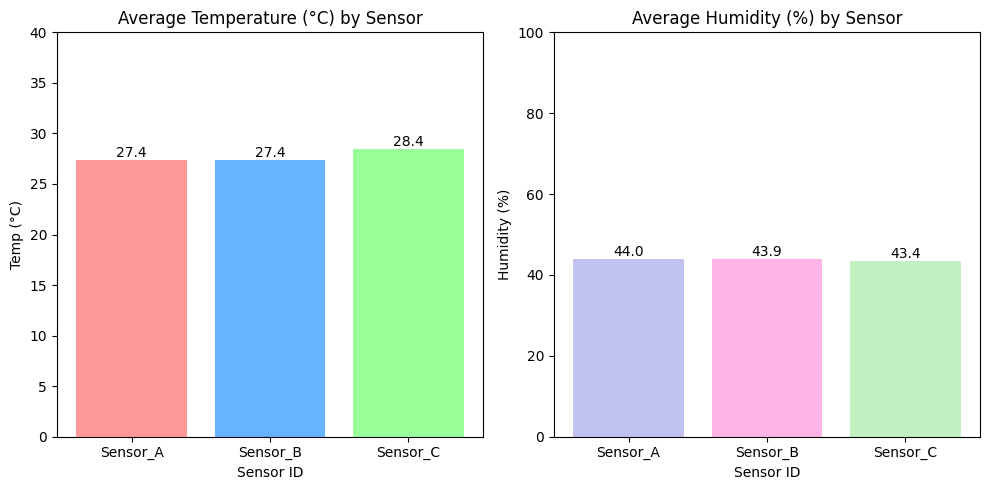

📊 Visualization Generated. Please take a screenshot of these charts!


In [9]:
# @title Step 5: Visualization Layer (Grafana Alternative)
# This satisfies the "Visualization" requirement using Matplotlib.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Load the data we saved in Step 4
# We read from the CSV to prove the Storage Layer works!
storage_path = "processed_storage/final_sensor_report.csv"
viz_df = pd.read_csv(storage_path).sort_values(by="device_id")

# 2. Create the Charts
plt.figure(figsize=(10, 5))

# Chart 1: Average Temperature per Sensor
plt.subplot(1, 2, 1)
# Define colors for the bars
colors = ['#ff9999', '#66b3ff', '#99ff99']
bars = plt.bar(viz_df['device_id'], viz_df['avg_temp'], color=colors)
plt.title('Average Temperature (°C) by Sensor')
plt.xlabel('Sensor ID')
plt.ylabel('Temp (°C)')
plt.ylim(0, 40) # Scale y-axis from 0 to 40

# Add text labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), va='bottom', ha='center')

# Chart 2: Average Humidity per Sensor
plt.subplot(1, 2, 2)
bars2 = plt.bar(viz_df['device_id'], viz_df['avg_humidity'], color=['#c2c2f0','#ffb3e6', '#c2f0c2'])
plt.title('Average Humidity (%) by Sensor')
plt.xlabel('Sensor ID')
plt.ylabel('Humidity (%)')
plt.ylim(0, 100) # Scale y-axis from 0 to 100

# Add text labels on top of bars
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), va='bottom', ha='center')

plt.tight_layout()
plt.show()

print("📊 Visualization Generated. Please take a screenshot of these charts!")